In [5]:
import tqdm

def nop(it, *a, **k):
    return it

real_tqdm = tqdm.tqdm
tqdm.tqdm = nop
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '2'

import time
import glob
import pickle

import numpy as np
np.bool = np.bool_
import cv2
import torch
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import torch.nn.functional as F

from utils.inference.image_processing import crop_face, get_final_image, show_images, normalize_and_torch, normalize_and_torch_batch
from utils.inference.video_processing import read_video, get_target, get_final_video, add_audio_from_another_video, face_enhancement, crop_frames_and_get_transforms, resize_frames
from utils.inference.core import model_inference, transform_target_to_torch
from utils.inference.faceshifter_run import faceshifter_batch, faceshifter_batch_zattrs
from network.AEI_Net import AEI_Net
from coordinate_reg.image_infer import Handler
from insightface_func.face_detect_crop_multi import Face_detect_crop
from arcface_model.iresnet import iresnet100
from models.pix2pix_model import Pix2PixModel
from models.config_sr import TestOptions

### Load Models

In [6]:
app = Face_detect_crop(name='antelope', root='./insightface_func/models')
app.prepare(ctx_id= 0, det_thresh=0.6, det_size=(640,640))

# main model for generation
G = AEI_Net(backbone='unet', num_blocks=2, c_id=512)
G.eval()
G.load_state_dict(torch.load('weights/G_unet_2blocks.pth', map_location=torch.device('cpu')))
G = G.cuda()
G = G.half()

# arcface model to get face embedding
netArc = iresnet100(fp16=False)
netArc.load_state_dict(torch.load('arcface_model/backbone.pth'))
netArc=netArc.cuda()
netArc.eval()

# model to get face landmarks
handler = Handler('./coordinate_reg/model/2d106det', 0, ctx_id=0, det_size=640)

# model to make superres of face, set use_sr=True if you want to use super resolution or use_sr=False if you don't
use_sr = True
if use_sr:
    torch.backends.cudnn.benchmark = True
    opt = TestOptions()
    #opt.which_epoch ='10_7'
    model = Pix2PixModel(opt)
    model.netG.train()

input mean and std: 127.5 127.5
find model: ./insightface_func/models/antelope/glintr100.onnx recognition
find model: ./insightface_func/models/antelope/scrfd_10g_bnkps.onnx detection
set det-size: (640, 640)
loading ./coordinate_reg/model/2d106det 0
input mean and std: 127.5 127.5
find model: ./insightface_func/models/antelope/glintr100.onnx recognition
find model: ./insightface_func/models/antelope/scrfd_10g_bnkps.onnx detection
set det-size: (640, 640)


[09:47:23] ../src/nnvm/legacy_json_util.cc:208: Loading symbol saved by previous version v1.5.0. Attempting to upgrade...
[09:47:23] ../src/nnvm/legacy_json_util.cc:216: Symbol successfully upgraded!


Network [LIPSPADEGenerator] was created. Total number of parameters: 72.2 million. To see the architecture, do print(network).
Load checkpoint from path:  weights/10_net_G.pth


### Set here path to source image and video for faceswap

# 특징 빼기 + 인젝션

# pca

In [ ]:
from insightface.utils import face_align
import ipywidgets as widgets

with open("./pca_pkl/zattrPCA.pkl", "rb") as file:
    pca = pickle.load(file)

crop_size = 224
set_target = False
half=True
similarity_th=0.15

crop_frames_list = None
target_batch_rs = None
image_to_image = True
start_id = 3
with open("./examples/z_embeds/VggFace2-crop/{}.pkl".format(start_id), "rb") as file:
    z_embed = pickle.load(file)
original_shape = [attr.shape for attr in z_embed]
pca_array = pca.transform(z_embed[0].reshape(1, -1))
for i in range(len(z_embed)):
    z_embed[i] = torch.from_numpy(z_embed[i]).half().to("cuda")
with open("./pca_pkl/zattrPCAMinMax.pkl", "rb") as file:
    pca_minmax = pickle.load(file)
pca_min = pca_minmax["min"]
pca_max = pca_minmax["max"]
source_id = 3
source_embed = torch.from_numpy(np.array([np.load("./examples/arc_embeds/VggFace2-crop/{}.npy".format(source_id))])).half().to("cuda")

def load_target(path_to_target='examples/images/tgt1.png'):
    global crop_frames_list, target_batch_rs
    target_full = cv2.imread(path_to_target)
    full_frames = [target_full]
    target = get_target(full_frames, app, crop_size)

    target_norm = normalize_and_torch_batch(np.array(target))
    target_embeds = netArc(F.interpolate(target_norm, scale_factor=0.5, mode='bilinear', align_corners=True))

    # Get the cropped faces from original frames and transformations to get those crops
    crop_frames_list, tfm_array_list = crop_frames_and_get_transforms(full_frames,
                                                                    target_embeds,
                                                                    app,
                                                                    netArc,
                                                                    crop_size,
                                                                    set_target,
                                                                    similarity_th=similarity_th
                                                                    )
    resized_frs, present = resize_frames(crop_frames_list[0])
    resized_frs = np.array(resized_frs)

    target_batch_rs = transform_target_to_torch(resized_frs, half=True)


load_target()


def inject_drawing():
    global crop_frames_list, pca_array, z_embed, source_embed
    plt.figure(num=1, clear=True, figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.imread("./examples/images/VggFace2-crop/n000003/0150_01.jpg")[:,:,::-1])
    plt.title("Target Face")
    plt.subplot(1, 2, 2)

    modified_embed = pca.inverse_transform(pca_array)
    z_embed[0] = torch.from_numpy(modified_embed.reshape(*original_shape[0])).half().to("cuda")
    #source_embed[0][0] = 10.0

    Y_st = faceshifter_batch_zattrs(source_embed, z_embed, 1, G)
    #Y_st = faceshifter_batch(source_embed, target_batch_rs[i:i+BS], G)

    torch.cuda.empty_cache()

    plt.imshow(Y_st[0][:, :, ::-1])
    plt.title("After Swap")
    plt.show()

pca_sliders = []

iact_plot = widgets.interactive(
    inject_drawing
)

for i in range(40):
    pca_slider = widgets.FloatSlider(
        value=pca_array[0, i], 
        min = pca_min[i],
        max = pca_max[i],
        description=f"PCA #{i}",
        continuous_update=False,
        layout=widgets.Layout(width="300px"),
    )
    pca_slider.idx = i
    pca_slider.observe(lambda change: exec("pca_array[0, change.owner.idx]=change.new;iact_plot.update()"), names="value")
    #pca_slider.observe(lambda change: print(change.owner.idx), names="value")
    pca_sliders.append(pca_slider)
    

slider_multibox = widgets.HBox(
    children=[
    widgets.VBox(
    children = pca_sliders[:20]),
    widgets.VBox(
    children = pca_sliders[20:]),
    ]
)


display(iact_plot, slider_multibox)


/compuworks/anaconda3/envs/xaiseung_ghost_cuda114/lib/python3.9/site-packages/ipywidgets/widgets/interaction.py:43: DeprecationWarning: `ipykernel.pylab.backend_inline` is deprecated, directly use `matplotlib_inline.backend_inline`
  from ipykernel.pylab.backend_inline import flush_figures


interactive(children=(Output(),), _dom_classes=('widget-interact',))

0
torch.Size([1, 1024, 2, 2])
torch.Size([4096])
1
torch.Size([1, 2048, 4, 4])
torch.Size([32768])
2
torch.Size([1, 1024, 8, 8])
torch.Size([65536])
3
torch.Size([1, 512, 16, 16])
torch.Size([131072])
4
torch.Size([1, 256, 32, 32])
torch.Size([262144])
5
torch.Size([1, 128, 64, 64])
torch.Size([524288])
6
torch.Size([1, 64, 128, 128])
torch.Size([1048576])
7
torch.Size([1, 64, 256, 256])
torch.Size([4194304])


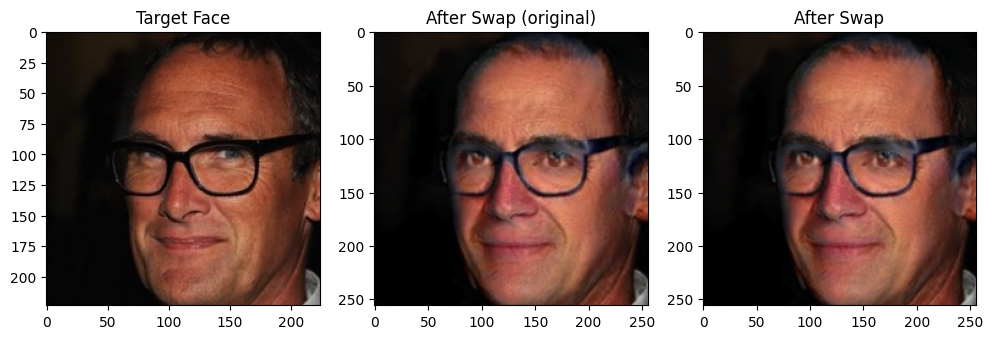

In [ ]:
from insightface.utils import face_align
import ipywidgets as widgets

with open("./pca_pkl/zattrPCA.pkl", "rb") as file:
    pca = pickle.load(file)

crop_size = 224

set_target = False
half=True
similarity_th=0.15

crop_frames_list = None
target_batch_rs = None
image_to_image = True
start_id = 3
with open("./examples/z_embeds/VggFace2-crop/{}.pkl".format(start_id), "rb") as file:
    z_embed = pickle.load(file)
original_shape = [attr.shape for attr in z_embed]
pca_array = pca.transform(z_embed[0].reshape(1, -1))
for i in range(len(z_embed)):
    z_embed[i] = torch.from_numpy(z_embed[i]).half().to("cuda")
with open("./pca_pkl/zattrPCAMinMax.pkl", "rb") as file:
    pca_minmax = pickle.load(file)
pca_min = pca_minmax["min"]
pca_max = pca_minmax["max"]
source_id = 381
source_embed = torch.from_numpy(np.array([np.load("./examples/arc_embeds/VggFace2-crop/{}.npy".format(source_id))])).half().to("cuda")

def load_target(path_to_target='examples/images/tgt1.png'):
    global crop_frames_list, target_batch_rs
    target_full = cv2.imread(path_to_target)
    full_frames = [target_full]
    target = get_target(full_frames, app, crop_size)

    target_norm = normalize_and_torch_batch(np.array(target))
    target_embeds = netArc(F.interpolate(target_norm, scale_factor=0.5, mode='bilinear', align_corners=True))

    # Get the cropped faces from original frames and transformations to get those crops
    crop_frames_list, tfm_array_list = crop_frames_and_get_transforms(full_frames,
                                                                    target_embeds,
                                                                    app,
                                                                    netArc,
                                                                    crop_size,
                                                                    set_target,
                                                                    similarity_th=similarity_th
                                                                    )
    resized_frs, present = resize_frames(crop_frames_list[0])
    resized_frs = np.array(resized_frs)

    target_batch_rs = transform_target_to_torch(resized_frs, half=True)


load_target()


def inject_drawing():
    global crop_frames_list, pca_array, z_embed, source_embed
    plt.figure(num=1, clear=True, figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.imread("./examples/images/VggFace2-crop/n000003/0150_01.jpg")[:,:,::-1])
    plt.title("Target Face")
    plt.subplot(1, 3, 2)
    
    Y_st = faceshifter_batch_zattrs(source_embed, z_embed, 1, G)
    #Y_st = faceshifter_batch(source_embed, target_batch_rs[i:i+BS], G)

    torch.cuda.empty_cache()

    plt.imshow(Y_st[0][:, :])
    plt.title("After Swap (original)")

    plt.subplot(1, 3, 3)
    #pca_array[0][:512] = 0
    #modified_embed = pca.inverse_transform(pca_array)
    #origin_z_embed = z_embed[0]
    #z_embed[0] = torch.from_numpy(modified_embed.reshape(*original_shape[0])).half().to("cuda")
    #print(torch.sum(abs(origin_z_embed-z_embed[0])).detach().cpu().item())
    #source_embed[0][0] = 10.0
    #z_embed[1][0, :, 0, 0] = -10
    z_embed[1][0, :1024, :, :] = 10
    for i in range(0,8):
        print(i)
        print(z_embed[i].shape)
        print(z_embed[i].flatten().shape)
        
    Y_st = faceshifter_batch_zattrs(source_embed, z_embed, 1, G)
    #Y_st = faceshifter_batch(source_embed, target_batch_rs[i:i+BS], G)

    torch.cuda.empty_cache()

    plt.imshow(Y_st[0][:, :])
    plt.title("After Swap")
    plt.show()

inject_drawing()

# zattr[4] 치환하기

In [28]:
from insightface.utils import face_align
import ipywidgets as widgets

zattr_id = 5

with open(f"./pca_pkl/zattr{zattr_id}PCA.pkl", "rb") as file:
    pca = pickle.load(file)

crop_size = 224

set_target = False
half=True
similarity_th=0.15

crop_frames_list = None
target_batch_rs = None
image_to_image = True
start_id = 3
with open("./examples/z_embeds/VggFace2-crop/{}.pkl".format(start_id), "rb") as file:
    z_embed = pickle.load(file)
original_shape = [attr.shape for attr in z_embed]
pca_array = pca.transform(z_embed[zattr_id].reshape(1, -1))
before_modi_embed = pca.inverse_transform(pca_array) 
for i in range(len(z_embed)):
    z_embed[i] = torch.from_numpy(z_embed[i]).half().to("cuda")
with open(f"./pca_pkl/zattr{zattr_id}PCAMinMax.pkl", "rb") as file:
    pca_minmax = pickle.load(file)
pca_min = pca_minmax["min"]
pca_max = pca_minmax["max"]
orig_z_embed = z_embed[zattr_id].detach().cpu().numpy()
source_id = 3
source_embed = torch.from_numpy(np.array([np.load("./examples/arc_embeds/VggFace2-crop/{}.npy".format(source_id))])).half().to("cuda")

def load_target(path_to_target='examples/images/tgt1.png'):
    global crop_frames_list, target_batch_rs
    target_full = cv2.imread(path_to_target)
    full_frames = [target_full]
    target = get_target(full_frames, app, crop_size)

    target_norm = normalize_and_torch_batch(np.array(target))
    target_embeds = netArc(F.interpolate(target_norm, scale_factor=0.5, mode='bilinear', align_corners=True))

    # Get the cropped faces from original frames and transformations to get those crops
    crop_frames_list, tfm_array_list = crop_frames_and_get_transforms(full_frames,
                                                                    target_embeds,
                                                                    app,
                                                                    netArc,
                                                                    crop_size,
                                                                    set_target,
                                                                    similarity_th=similarity_th
                                                                    )
    resized_frs, present = resize_frames(crop_frames_list[0])
    resized_frs = np.array(resized_frs)

    target_batch_rs = transform_target_to_torch(resized_frs, half=True)


load_target()


def inject_drawing():
    global crop_frames_list, pca_array, z_embed, source_embed
    plt.figure(num=1, clear=True, figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.imread("./examples/images/VggFace2-crop/n000003/0150_01.jpg")[:,:,::-1])
    plt.title("Target Face")
    plt.subplot(1, 2, 2)

    modified_embed = pca.inverse_transform(pca_array)
    embed_diff =  modified_embed - before_modi_embed
    z_embed[zattr_id] = torch.from_numpy(orig_z_embed+embed_diff.reshape(*original_shape[zattr_id])).half().to("cuda")
    #source_embed[0][0] = 10.0

    Y_st = faceshifter_batch_zattrs(source_embed, z_embed, 1, G)
    #Y_st = faceshifter_batch(source_embed, target_batch_rs[i:i+BS], G)

    torch.cuda.empty_cache()

    plt.imshow(Y_st[0][:, :, ])
    plt.title("After Swap")
    plt.show()

pca_sliders = []

iact_plot = widgets.interactive(
    inject_drawing
)

for i in range(40):
    pca_slider = widgets.FloatSlider(
        value=pca_array[0, i], 
        min = pca_min[i],
        max = pca_max[i],
        description=f"PCA #{i}",
        continuous_update=False,
        layout=widgets.Layout(width="300px"),
    )
    pca_slider.idx = i
        
        
    pca_slider.observe(lambda change: exec("pca_array[0, change.owner.idx]=change.new;iact_plot.update()"), names="value")
    #pca_slider.observe(lambda change: print(change.owner.idx), names="value")
    pca_sliders.append(pca_slider)
    

slider_multibox = widgets.HBox(
    children=[
    widgets.VBox(
    children = pca_sliders[:20]),
    widgets.VBox(
    children = pca_sliders[20:]),
    ]
)


display(iact_plot, slider_multibox)


interactive(children=(Output(),), _dom_classes=('widget-interact',))

# PCA 값에 따른 변화 그림

In [ ]:
# 재미용
set_target = False
half=True
similarity_th=0.15
crop_size=224

fig_save_dir = "./pca_figs"
os.makedirs(fig_save_dir, exist_ok=True)

for zattr_id in [2, 3, 4, 5, 6, 7]:

    with open(f"./pca_pkl/Altered_zattr{zattr_id}PCA.pkl", "rb") as file:
        pca = pickle.load(file)


    with open(f"./pca_pkl/Altered_zattr{zattr_id}PCAMinMax.pkl", "rb") as file:
        pca_minmax = pickle.load(file)
    pca_min = pca_minmax["min"]
    pca_max = pca_minmax["max"]
    pca_orig_range = pca_max - pca_min
    pca_min -= pca_orig_range*0.3
    pca_max += pca_orig_range*0.3

    start_id = 0
    #tmp_embed = [np.load("./embeds/{}.npy".format(start_id))]
    #pca_array = pca.transform(tmp_embed)

    start_id = 10
    z_embed = None
    original_shape = None
    pca_array = None
    orig_z_embed = None

    def load_target(path_to_target='examples/images/tgt1.png'):
        global z_embed, zattr_id, original_shape, pca_array, orig_z_embed
        target_full = cv2.imread(path_to_target)
        full_frames = [target_full]
        target = get_target(full_frames, app, crop_size)

        target_norm = normalize_and_torch_batch(np.array(target))
        target_embeds = netArc(F.interpolate(target_norm, scale_factor=0.5, mode='bilinear', align_corners=True))

        # Get the cropped faces from original frames and transformations to get those crops
        crop_frames_list, tfm_array_list = crop_frames_and_get_transforms(full_frames,
                                                                        target_embeds,
                                                                        app,
                                                                        netArc,
                                                                        crop_size,
                                                                        set_target,
                                                                        similarity_th=similarity_th
                                                                        )
        resized_frs, present = resize_frames(crop_frames_list[0])
        resized_frs = np.array(resized_frs)

        target_batch_rs = transform_target_to_torch(resized_frs, half=True)

        zattrs = G.get_attr(target_batch_rs)
        zattrs = list(zattrs)
        for i in range(len(zattrs)):
            zattrs[i] = zattrs[i]
        z_embed = zattrs
        original_shape = [attr.shape for attr in z_embed]
        orig_z_embed = z_embed[zattr_id].detach().cpu().numpy()
        pca_array = pca.transform(orig_z_embed.reshape(1, -1))

    load_target(path_to_target="examples/images/tgt1.png")



    source_id = 3
    source_pic = "examples/images/elon_musk.jpg"

    #source_embed = torch.from_numpy(np.array([np.load("./examples/arc_embeds/VggFace2-crop/{}.npy".format(source_id))])).half().to("cuda")
    source_full = cv2.imread(source_pic)
    full_frames = [source_full]
    #print(source_full.shape)
    source = crop_face(source_full, app, crop_size)[0][:,:,::-1]
    source_curr = source
    #target = [source_curr.copy()]
    source_curr = normalize_and_torch(source_curr)
    #print(source_curr.shape)
    source_embed = netArc(F.interpolate(source_curr, scale_factor=0.5, mode='bilinear', align_corners=True)).half()

    num_plotted_pca = 50
    n_ticks = 5

    plt.figure(num=1, clear=True, figsize=(n_ticks*2, int(num_plotted_pca*1.75)))
    plt.subplot(num_plotted_pca+1,n_ticks, 1)
    plt.imshow(cv2.imread(source_pic)[:,:,::-1])
    plt.title("Target Face")
    plt.axis("off")
    plt.subplot(num_plotted_pca+1,n_ticks,2)

    Y_st = faceshifter_batch_zattrs(source_embed, z_embed, 1, G)
    torch.cuda.empty_cache()

    plt.imshow(Y_st[0][:, :,::-1])
    plt.title("Swapped (origin)")
    #plt.axis("off")
    for side in ["top", "right", "bottom", "left"]: plt.gca().spines[side].set_visible(False)
    plt.xticks([])
    plt.yticks([])



    for pci_i in range(num_plotted_pca):
        interval = (pca_max[pci_i] - pca_min[pci_i]) / (n_ticks-1)
        for c in range(n_ticks):
            plt.subplot(num_plotted_pca+1,n_ticks, (pci_i+1)*n_ticks+c+1)
            new_pca_array = pca_array.copy()
            before_modi_embed = pca.inverse_transform(new_pca_array) 
            new_pca_array[0, pci_i] = pca_min[pci_i] + (interval * c)
            modified_embed = pca.inverse_transform(new_pca_array)
            embed_diff =  modified_embed - before_modi_embed
            z_embed[zattr_id] = torch.from_numpy(orig_z_embed+embed_diff.reshape(*original_shape[zattr_id])).half().to("cuda")
            #source_embed[0][0] = 10.0

            Y_st = faceshifter_batch_zattrs(source_embed, z_embed, 1, G)
            #Y_st = faceshifter_batch(source_embed, target_batch_rs[i:i+BS], G)

            plt.imshow(Y_st[0][:, :,::-1])
            #plt.title("Swapped Face ")
            #plt.axis("off")
            for side in ["top", "right", "bottom", "left"]: plt.gca().spines[side].set_visible(False)
            plt.xticks([])
            plt.yticks([])
            plt.xlabel(f"{new_pca_array[0, pci_i]:.2f}")

            if c == 0:
                plt.ylabel("PCA #{}".format(pci_i))

    plt.tight_layout()
    save_path = f"{fig_save_dir}/AlterPCA_for_zattr[{zattr_id}]_tgt{source_id}_to{num_plotted_pca}.png"
    plt.savefig(save_path)
    plt.close()
    print(f"saved at {save_path}")

# zattr[i]

In [ ]:


load_target = False
half=True
similarity_th=0.15

crop_frames_list = None
target_batch_rs = None

for zattr_id in [1, 2, 3, 4, 5, 6, 7]: 

    with open(f"./pca_pkl/zattr{zattr_id}PCA.pkl", "rb") as file:
        pca = pickle.load(file)



    with open(f"./pca_pkl/zattr{zattr_id}PCAMinMax.pkl", "rb") as file:
        pca_minmax = pickle.load(file)
    pca_min = pca_minmax["min"]
    pca_max = pca_minmax["max"]
    pca_orig_range = pca_max - pca_min
    pca_min -= pca_orig_range*0.1
    pca_max += pca_orig_range*0.1

    #tmp_embed = [np.load("./embeds/{}.npy".format(start_id))]
    #pca_array = pca.transform(tmp_embed)

    start_id = 10
    with open("./examples/z_embeds/VggFace2-crop/{}.pkl".format(start_id), "rb") as file:
        z_embed = pickle.load(file)
    original_shape = [attr.shape for attr in z_embed]
    pca_array = pca.transform(z_embed[zattr_id].reshape(1, -1))
    orig_z_embed = z_embed[zattr_id]
    for i in range(len(z_embed)):
        z_embed[i] = torch.from_numpy(z_embed[i]).half().to("cuda")
        
    source_id = 3
    source_embed = torch.from_numpy(np.array([np.load("./examples/arc_embeds/VggFace2-crop/{}.npy".format(source_id))])).half().to("cuda")


    num_plotted_pca = 40
    n_ticks = 5

    plt.figure(num=1, clear=True, figsize=(n_ticks*2, int(num_plotted_pca*1.75)) )
    plt.subplot(num_plotted_pca+1,n_ticks, 1)
    plt.imshow(cv2.imread("./examples/images/VggFace2-crop/n000007/0112_01.jpg")[:,:,::-1])
    plt.title("Target Face")
    plt.axis("off")
    plt.subplot(num_plotted_pca+1,n_ticks,2)

    Y_st = faceshifter_batch_zattrs(source_embed, z_embed, 1, G)
    torch.cuda.empty_cache()

    plt.imshow(Y_st[0][:, :,])
    plt.title("Swapped (origin)")
    #plt.axis("off")
    for side in ["top", "right", "bottom", "left"]: plt.gca().spines[side].set_visible(False)
    plt.xticks([])
    plt.yticks([])



    for pci_i in range(num_plotted_pca):
        interval = (pca_max[pci_i] - pca_min[pci_i]) / (n_ticks-1)
        for c in range(n_ticks):
            plt.subplot(num_plotted_pca+1,n_ticks, (pci_i+1)*n_ticks+c+1)
            new_pca_array = pca_array.copy()
            before_modi_embed = pca.inverse_transform(new_pca_array) 
            new_pca_array[0, pci_i] = pca_min[pci_i] + (interval * c)
            modified_embed = pca.inverse_transform(new_pca_array)
            embed_diff =  modified_embed - before_modi_embed
            z_embed[zattr_id] = torch.from_numpy(orig_z_embed+embed_diff.reshape(*original_shape[zattr_id])).half().to("cuda")
            #source_embed[0][0] = 10.0

            Y_st = faceshifter_batch_zattrs(source_embed, z_embed, 1, G)
            #Y_st = faceshifter_batch(source_embed, target_batch_rs[i:i+BS], G)

            plt.imshow(Y_st[0][:, :,])
            #plt.title("Swapped Face ")
            #plt.axis("off")
            for side in ["top", "right", "bottom", "left"]: plt.gca().spines[side].set_visible(False)
            plt.xticks([])
            plt.yticks([])
            plt.xlabel(f"{new_pca_array[0, pci_i]:.2f}")

            if c == 0:
                plt.ylabel("PCA #{}".format(pci_i))

    save_path = f"{fig_save_dir}/PCA_for_zattr[{zattr_id}]_tgt{source_id}_to{num_plotted_pca}.png"
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()
    print(f"saved at {save_path}")